# Project: Soccer Data Analysis

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


The data that is used in this project came from the "Soccer Database" and the "database.sqlite" was uploaded to the workspace.

In this project, I will analyze this data to find out which betting company returns the most betting money for each league if I always bet $1 on the result with the highest betting odd, and which league returns the most betting money based on the same criteria.

Note that I mistakenly used the word 'bid' instead of 'bet' in variable names and some comments and I do not want to update them now because updating them might result in errors while running the code.

In [25]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import math
import numpy as np
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

To acquire data to answer the questions 

"Which betting company returns the most betting money for each league if I always bet $1 on the result with the highest betting odd"

I need to collect betting odds data for all matches in each league. Because we need to perform SQL aggregations and data cleaning, it will be more performant to operate on smaller set of data. Hence, I will acquire required betting data for each league seperately and store them in pandas's DataFrames. Here are the steps required to acquire the data:

1. Get a list of all leagues from the 'League' table in the database.sqlite via the api 'pd.read_sql_query'
2. Because I have already done the initial exploratory data analysis, I noticed that we do not have enough data for some leagues and some betting companies (Most data is NULL). Hence, I will exclude those leagues and betting companies from this analysis.
3. To get betting data for each league,
3.1 I will SELECT the 'season', 'home_team_goal', 'away_team_goal' and betting odds for each company for a particular league where I will use the SQL join with the 'League' table and the 'Match' table to match the 'league_id' and only scope the data to the league under analysis.
3.2 In addition, I will use the CASE clause to create a 'winning_result' column which compare a number of home team and away team goals and assigned either the letter 'H', 'D', and 'A' based on the comparison results. I will also use the CASE clause to create a '_max_bidding' column (suppose to be max_betting but I do not want to update my code now) for each betting company which stores a letter that represents a column with the highest betting odds ('H', 'D', or 'A')

4. The results in the step 3 will be stored in temporary SQL table 't_match'.
5. The temporary SQL table 't_match' will be used to create another temporary SQL table 't_match' which contains all data in t_match + a new column '_win_bid' for each betting company. The '_win_bid' column stores either a value 1 or 0 where 1 means that a column with the highest betting odds matches the actual game result (This means that we will get the betting money from this match) and 0 means that a column with the highest betting odds does NOT match the actual game result (This means that we will lose money from this bet)

6. Use the SQL query created from steps 3 to 5 above to get data via the api 'pd.read_sql_query' and store the data in a pandas DataFrame

7. Create a copy of the DataFrame in the step6 and add a new column '_bid_money' for each betting company and use the pandas's apply function to 
7.1 Compute the betting money for each match (I will get $1xbetting_odds if I win the bet and $-1 otherwise)
7.2 Clean up the '_win_bid' column where replace the value in this column with 0 if the betting odds data is not available (NULL)

8. After getting all necessary data, I will group the DataFrame by the 'season' column and find the total sum values of the '_bid_money' and '_win_bid' columns for each season and store this DataFrame in the dictionary "allBiddingResults[league_name]"

9. Repeat steps 3 to 8 for other leagues


In [26]:
# Helper functions

def getSelectForMaxCategory(bidding_company):
    """
    Return a SELECT clause to specify Home/Draw/Away win odds columns for the specified bidding company name
    and also create a new column "company_max_bidding" which stores a value to indicate which win odds column
    has the highest odds value.
    """
    
    name_h = "m." + bidding_company + "H";
    name_d = "m." + bidding_company + "D";
    name_a = "m." + bidding_company + "A";
    name_cat = bidding_company + "_max_bidding";
    
    select_str = name_h + ",\n" + \
        name_d + ",\n" + \
        name_a + ",\n" + \
        "CASE\n" + \
            "WHEN ( ( " + name_h + " > " + name_d + " ) AND ( " + name_h + " > " + name_a + " ) ) THEN 'H'\n" + \
            "WHEN ( ( " + name_d + " > " + name_h + " ) AND ( " + name_d + " > " + name_a + " ) ) THEN 'D'\n" + \
            "ELSE 'A' END AS " + name_cat;
        
    return select_str;


def getSelectForWinBidding(bidding_company):
    """
    Return a SELECT clause to create a new column "company_max_bidding" which stores a value to indicate whether 
    the actual match result matches the win odds column with the highest odds value
    """
    
    select_str = "" + \
    "        CASE\n" + \
    "            WHEN (winning_result = " + bidding_company + "_max_bidding) THEN 1 \n" + \
    "            ELSE 0 END AS " + bidding_company + "_win_bid";
    
    return select_str;

def getBiddingColumns(bidding_company):
    """
    Return a list of columns that need for the analysis for a given bidding company
    """
    
    return [bidding_company + '_max_bidding', \
            bidding_company + 'H', \
            bidding_company + 'D', \
            bidding_company + 'A', \
            bidding_company + '_win_bid'];

In [27]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

# ----------------------
# Start sqlite connection
# ----------------------
conn = sqlite3.connect("database.sqlite")

# ----------------------
# Retrieve data
# ----------------------

## STEP 1:

# Get all league names
allLeaguesFromDB = pd.read_sql_query("SELECT name FROM League", conn);


## STEP 2:

# Exclude "PS", "GB" and "BS" because we don't have bidding data in many seasons
bidding_companies = [
    "B365",
    "BW",
    "IW",
    "LB",
    "WH",
    "SJ",
    "VC"
];

# The following leagues do not have bidding data. Hence, skip them.
excludedLeagues = ["Poland Ekstraklasa", "Switzerland Super League"];

allLeagues = [];

# Get league names that we will use in the analysis
for cnt in range(len(allLeaguesFromDB.values)):
    league_name = allLeaguesFromDB.values[cnt][0];
    
    if (league_name not in excludedLeagues):
        allLeagues.append(league_name);


# Get bidding data for each league
allBiddingResults = {};
for cnt in range(len(allLeagues)):
    league_name = allLeagues[cnt];
    print('Start getting data for "' + league_name + '"')

    ## STEPS 3, 4, 5, 6
    
    # Create a SQL query to get bidding data
    select_cat_str = "";
    select_winbid_str = "";

    for cnt in range(len(bidding_companies)):
        
        cur_company = bidding_companies[cnt];
        select_cat_str += getSelectForMaxCategory(cur_company);
        select_winbid_str += getSelectForWinBidding(cur_company);
        if cnt != (len(bidding_companies) - 1):
            select_cat_str += ",";
            select_winbid_str += ",";

        select_cat_str += "\n";
        select_winbid_str += "\n";

    query = "" + \
        "WITH t_match AS (\n" + \
        "SELECT\n" + \
        "        m.season,\n" + \
        "        m.home_team_goal,\n" + \
        "        m.away_team_goal,\n" + \
        "        CASE\n" + \
        "            WHEN (m.home_team_goal > m.away_team_goal) THEN 'H'\n" + \
        "            WHEN (m.home_team_goal < m.away_team_goal) THEN 'A'\n" + \
        "            ELSE 	'D' 	END 	AS winning_result,\n" + \
        select_cat_str + \
        "From League l \n" + \
        "    JOIN Match m \n" + \
        "        ON m.league_id = l.id \n" + \
        "        AND  l.name IN ('" + league_name + "') \n" + \
        "),\n" + \
        "t_match2 AS (\n" + \
        "    SELECT\n" + \
        "        *,\n" + \
        "        " + select_winbid_str + \
        "    FROM t_match \n" + \
        ")\n" + \
        "SELECT * \n" + \
        "    FROM t_match2 \n";

    df = pd.read_sql_query(query, conn)
    
    # Only get data from columns that are required for the analysis
    # and compute the bidding money (-1 if lose the bidding and use the bidding odds values otherwise)
    columns_bidding = ['season','winning_result'];
    for cnt in range(len(bidding_companies)):
        cur_company = bidding_companies[cnt];
        cur_bidding_columns = getBiddingColumns(cur_company);
        columns_bidding += cur_bidding_columns;

    df1 = df[columns_bidding].copy();

    for cnt in range(len(bidding_companies)):
        cur_company = bidding_companies[cnt];
            
        def addBidMoneyColumn(x):
            bid_col_name = cur_company + x['winning_result'];

            # -1 when not winning bid
            bid_money = -1;
            if (x[cur_company + '_win_bid'] == 1):
                bid_money = x[bid_col_name];
            else:
                # Set bid_money = 0 if the betting odds are NULL (only check for *H is enough)
                if(math.isnan(x[cur_company + 'H'])):
                    bid_money = 0;

            return bid_money;

        df1[cur_company + '_bid_money'] = df1.apply(addBidMoneyColumn,axis=1);
    
    # Get a total of a number of winning bid and the total bidding money for each season
    # and store it in the dictionary "allBiddingResults"
    columns_results = [];
    for cnt in range(len(bidding_companies)):
        cur_company = bidding_companies[cnt];

        columns_results.append(cur_company + '_win_bid');
        columns_results.append(cur_company + '_bid_money');
    
    allBiddingResults[league_name] = df1.groupby('season').sum().loc[:, columns_results];
    
print('* Finish loading data');
# ----------------------
# Close sqlite connection
# ----------------------
conn.close()

Start getting data for "Belgium Jupiler League"
Start getting data for "England Premier League"
Start getting data for "France Ligue 1"
Start getting data for "Germany 1. Bundesliga"
Start getting data for "Italy Serie A"
Start getting data for "Netherlands Eredivisie"
Start getting data for "Portugal Liga ZON Sagres"
Start getting data for "Scotland Premier League"
Start getting data for "Spain LIGA BBVA"
* Finish loading data


### Data Cleaning (Update a number of winning bet when betting odds are not available)

To ease the analysis process, I will create a dictional with the field name 'numwins' and 'moneys' and store DataFrames that contain a number of winning bets and the betting money for each league, and columns in those DataFrames will be renamed to remove suffix and only use the betting company names for those columns.

Additionally, although I already acquired and cleaned the betting data for each league and store each of them in the dictionary 'allBiddingResults' in the previous step, I still need to clean up data in the '_win_bid' column for each betting company to replace the value in this column with 0 if the betting money is 0 (This means that the betting data is not available for that season)


The cleaning data above will be store in a new dictionary 'allBiddingResults_split'

In [28]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.

allBiddingResults_split = {};
for cnt in range(len(allLeagues)):
    league_name = allLeagues[cnt];
    
    columns_win_bid = [];
    columns_bid_money = [];

    new_columns_win_bid = {};
    new_columns_bid_money = {};

    for cnt in range(len(bidding_companies)):
        curCompany = bidding_companies[cnt];

        columns_win_bid.append(curCompany + '_win_bid');
        columns_bid_money.append(curCompany + '_bid_money');

        new_columns_win_bid[curCompany + '_win_bid'] = curCompany;
        new_columns_bid_money[curCompany + '_bid_money'] = curCompany;


    df_win_bid = allBiddingResults[league_name].loc[:, columns_win_bid].copy();
    df_win_bid.rename(columns=new_columns_win_bid, inplace=True)

    df_bid_money = allBiddingResults[league_name].loc[:, columns_bid_money].copy();
    df_bid_money.rename(columns=new_columns_bid_money, inplace=True)
    
    numSeasons = df_bid_money.shape[0];
    
    ## Clean up data
    
    for cnt in range(len(bidding_companies)):
        curCompany = bidding_companies[cnt];
    
        # Make a number of wins to 0 if bidding odds data is not available
        indice = df_bid_money[curCompany].index[df_bid_money[curCompany] == 0];
        df_win_bid[curCompany].loc[indice] = 0;
        
        # Use the average number to fill NaN - don't need it now
#         if (len(indice) > 0):
                        
#             sumVal = df_bid_money[curCompany].sum();
#             lenMean = numSeasons - len(indice);
            
#             avgVal = df_bid_money[curCompany].sum() / lenMean;
#             df_bid_money[curCompany].loc[indice] = avgVal;


    
    allBiddingResults_split[league_name] = {'numwins': df_win_bid, 'money': df_bid_money};


<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (Which Betting Company gives the most betting return)

***********************************
***** Belgium Jupiler League *****
***********************************


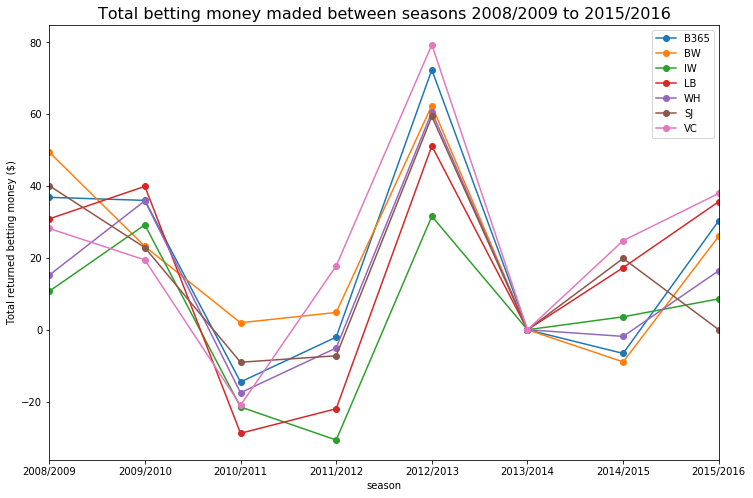

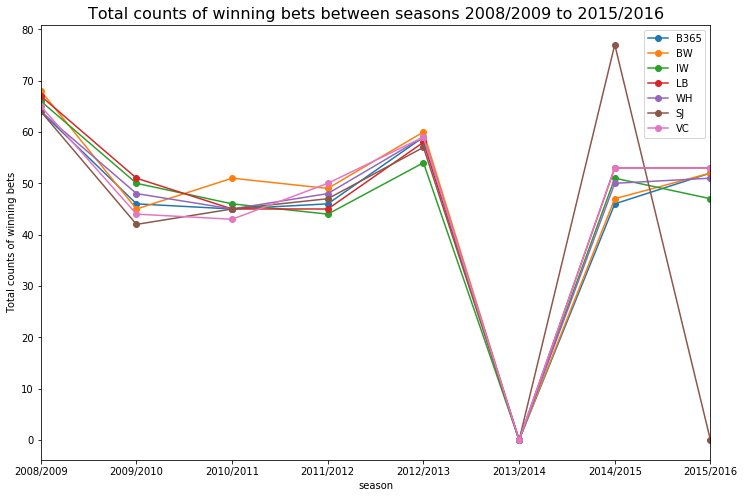

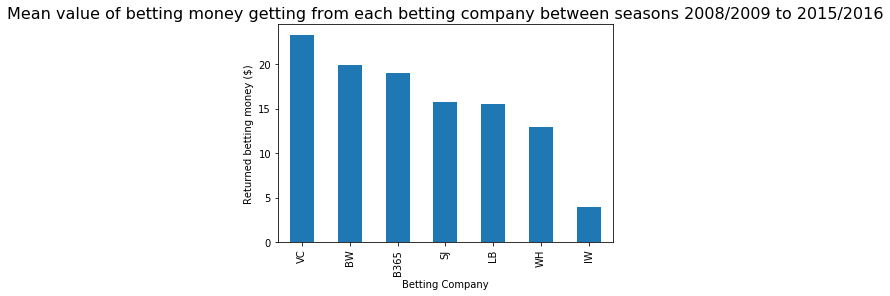

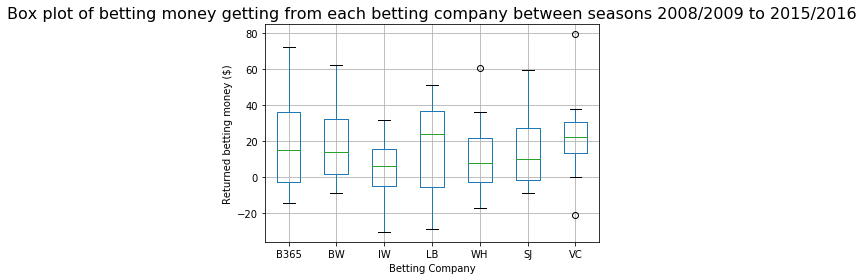

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, the total returned betting money will be little positive and negative for the seasons 2010/2011, 2011/2012, 2014/2015 
2) The betting data is not available for the season 2013/2014
3) In average, the betting company "VC" will returned the most betting money with the current betting criteria


***********************************
***** England Premier League *****
***********************************


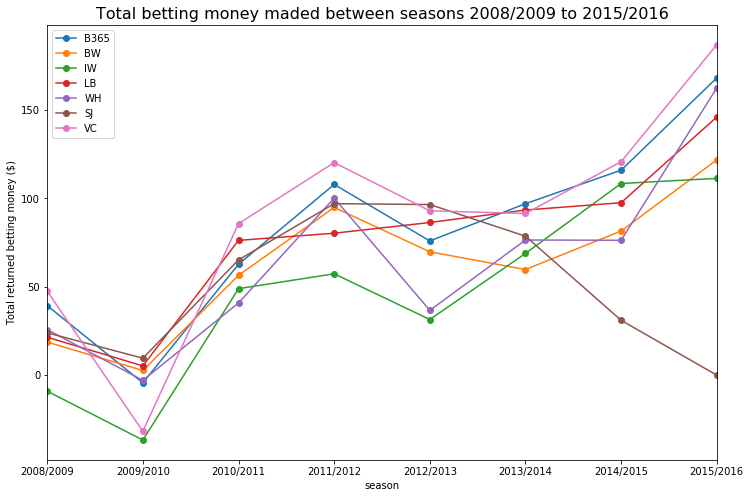

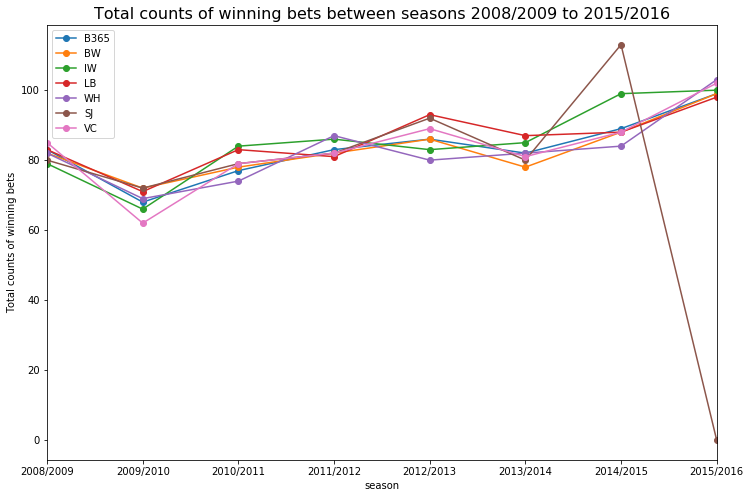

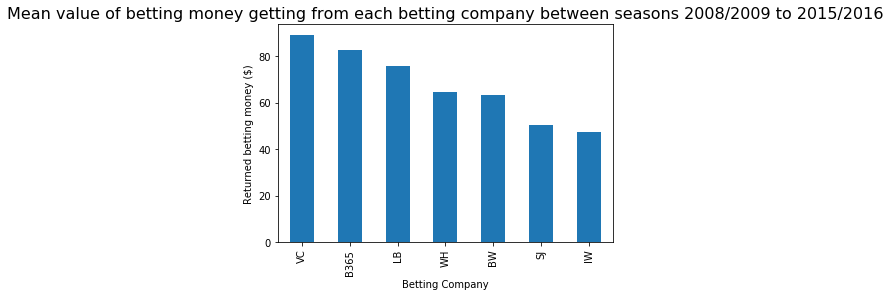

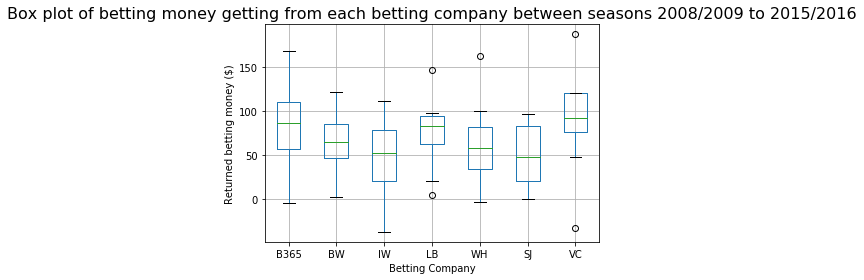

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, in the season 2009/2010, we will lose money for some betting companies and will gain little money from the rest
2) However, the line chart for the returned betting money shows that, after the season 2009/2010, the returned betting data will be increased quite significantly with the current betting criteria
3) In average, the betting company "VC" will returned the most betting money with the current betting criteria


***********************************
***** France Ligue 1 *****
***********************************


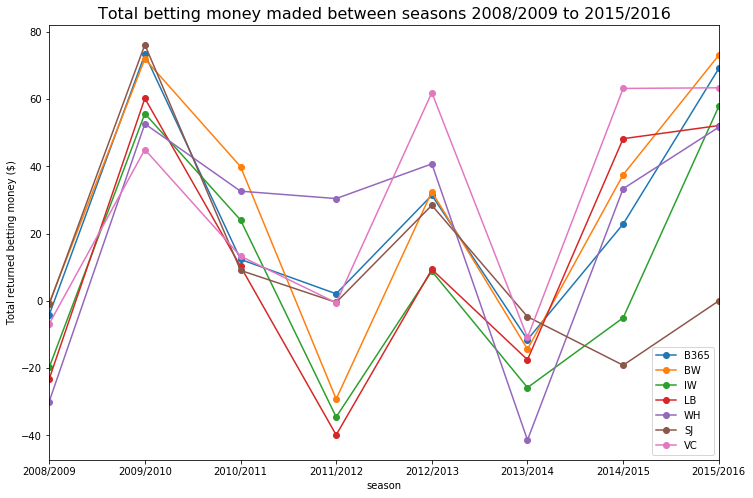

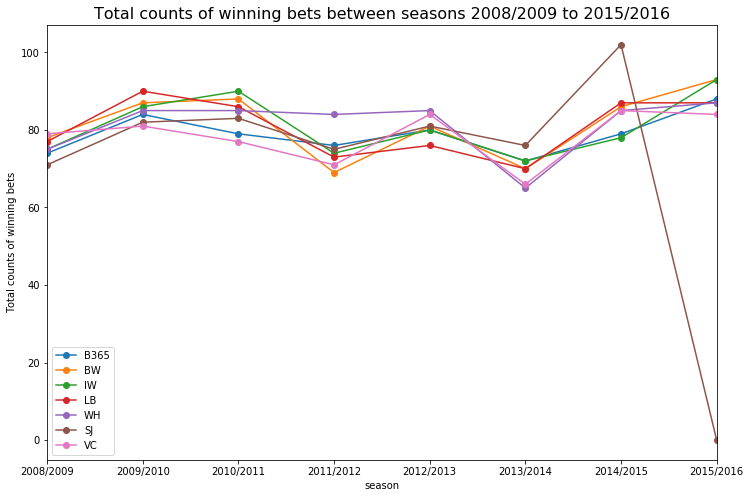

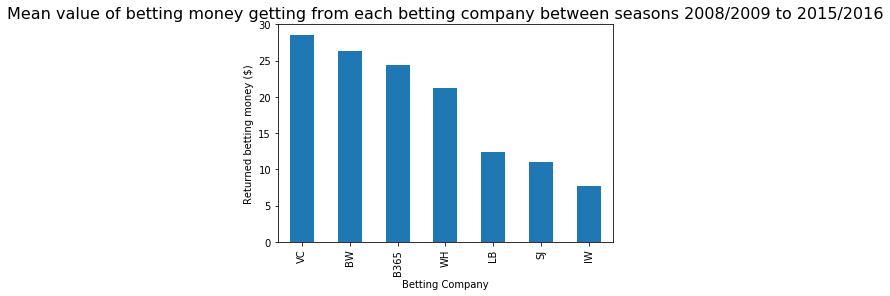

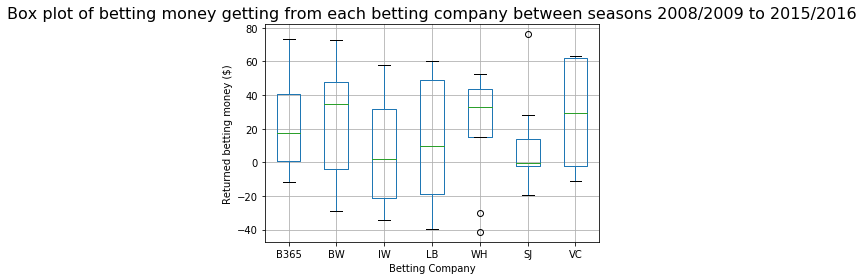

+++++++++++++++++++++++++++++++++++
Observations: 
1) The line for the returned betting money shows both negative and positive returned betting money in the seasons 2011/2012, 2013/2014, and 2014/2015
2) In average, the betting company "VC" will returned the most betting money with the current betting criteria although is not quite significant as in other leagues


***********************************
***** Germany 1. Bundesliga *****
***********************************


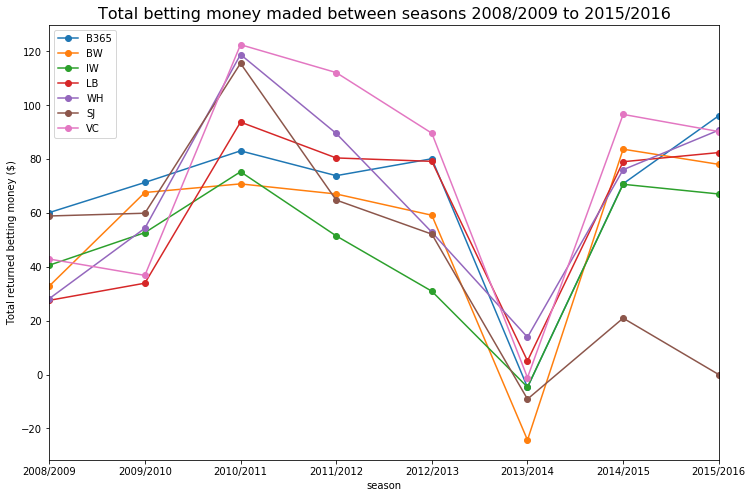

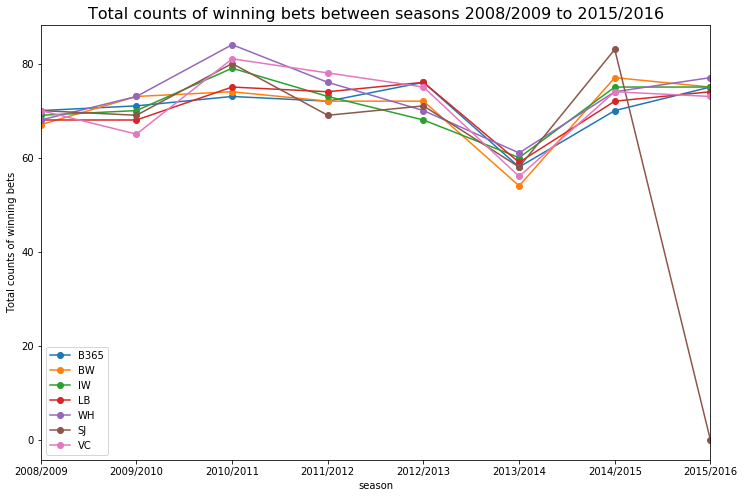

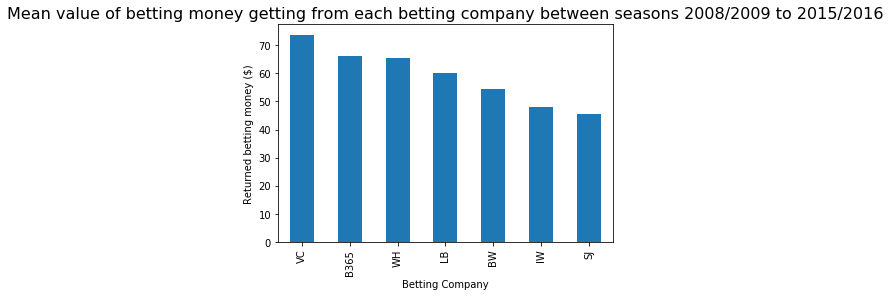

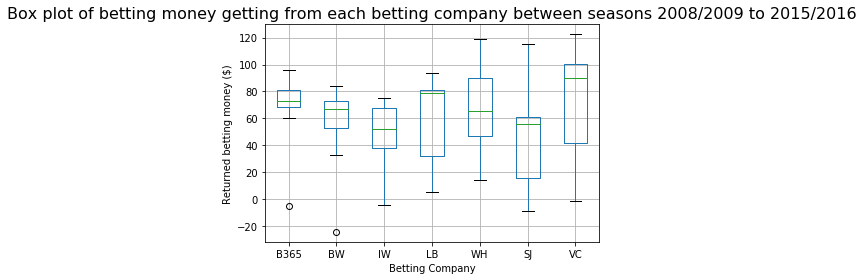

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, in the season 2013/2014, we will lose money for some betting companies and will gain little money from the rest
2) In average, the betting company "VC" will returned the most betting money with the current betting criteria


***********************************
***** Italy Serie A *****
***********************************


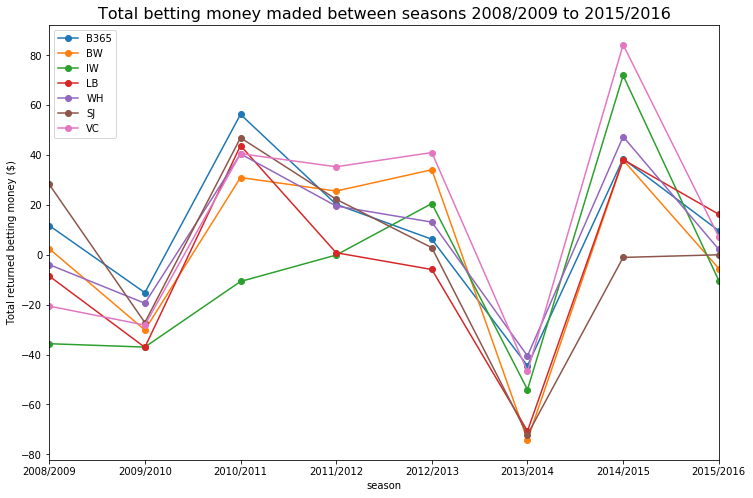

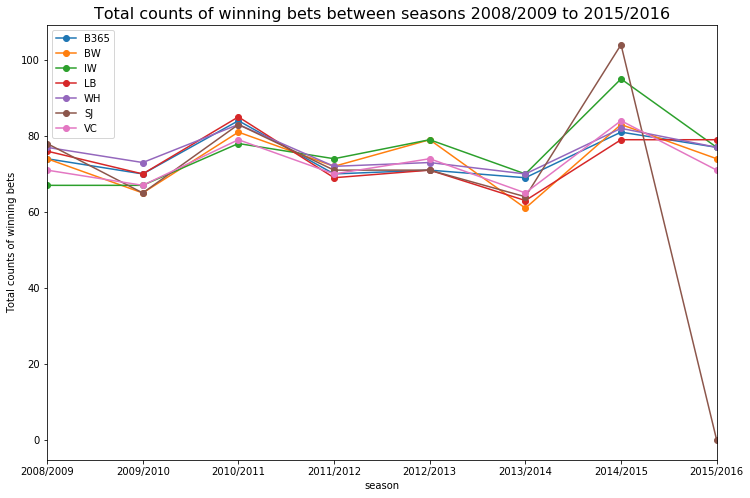

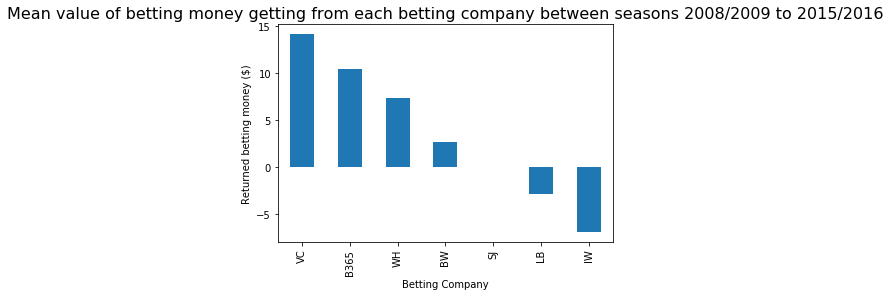

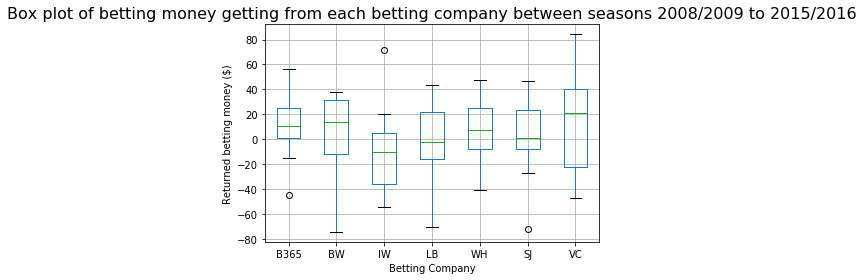

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, the total returned betting money will be negative for the seasons 2009/2010 and 2013/2014 and other seasons will have both positive and negative values
2) In average, the betting company "VC" will returned the most betting money with the current betting criteria and this value is much smaller than other leagues. Additionally, some bettings companies will return the negative betting money with the current betting criteria


***********************************
***** Netherlands Eredivisie *****
***********************************


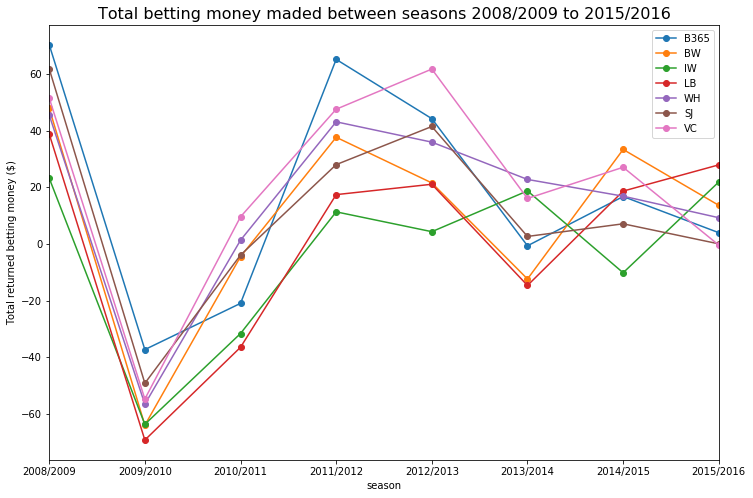

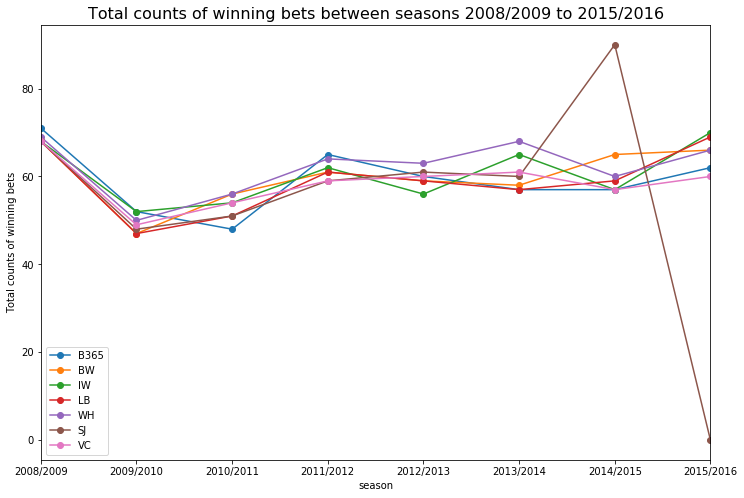

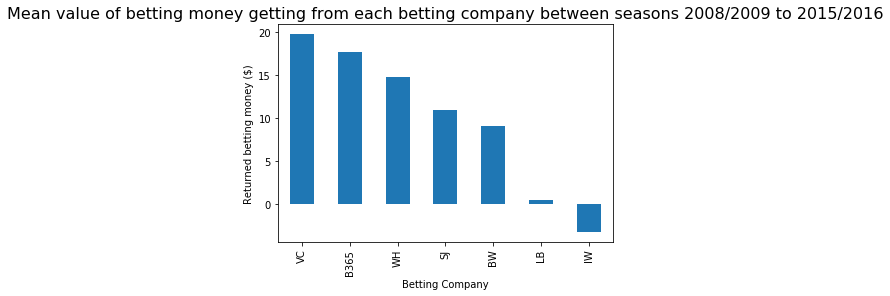

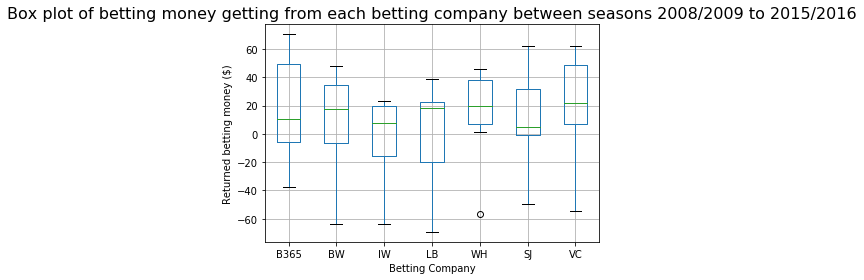

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, we will lose a lot of money from all betting companies in the season 2009/2010, we will both lose and gain money for other seasons
2) In average, the betting company "VC" will returned the most betting money with the current betting criteria and this value is much smaller than other leagues. Additionally, some bettings companies will return the negative betting money with the current betting criteria


***********************************
***** Portugal Liga ZON Sagres *****
***********************************


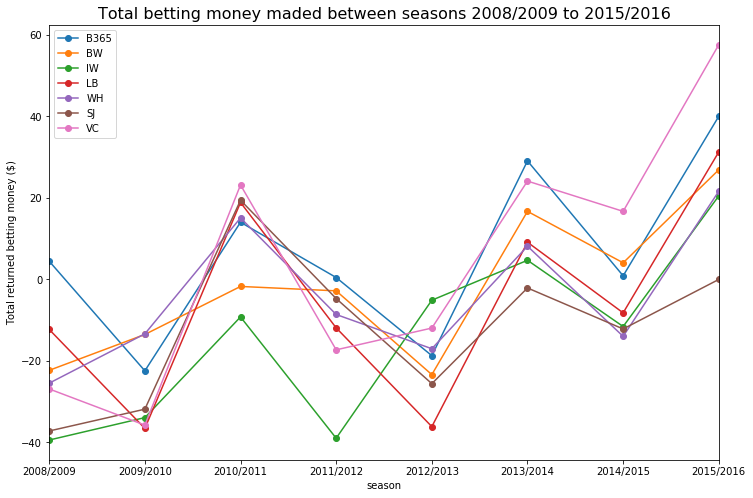

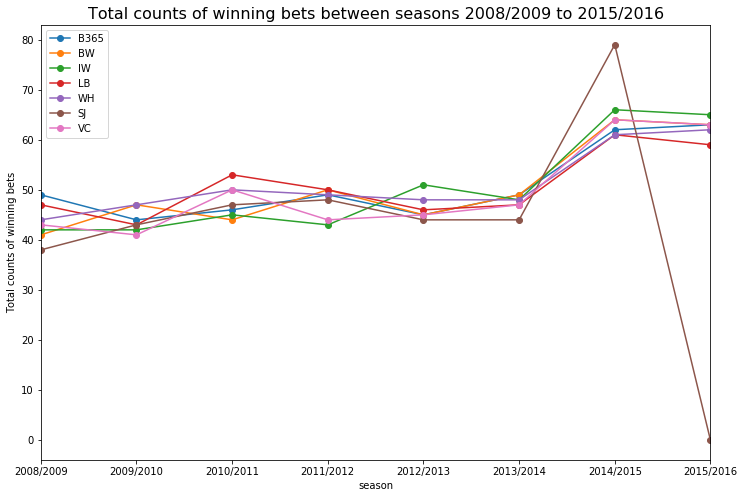

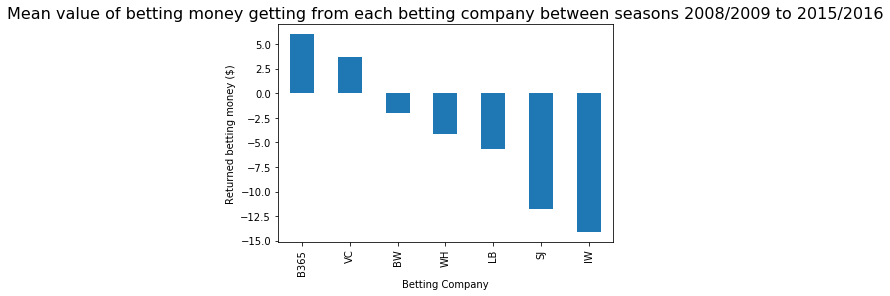

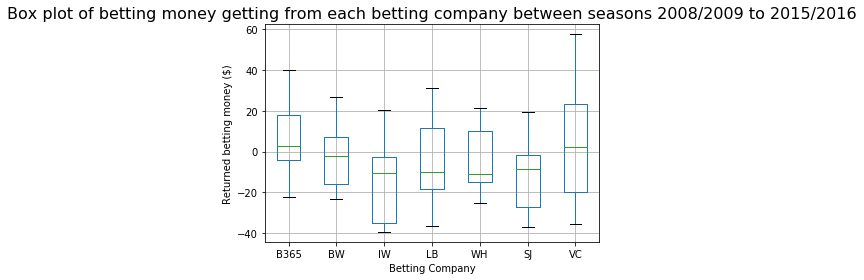

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, we will lose a lot of money from all betting companies in the seasons 2009/2010, 2011/2012 and 2012/2013, we will both lose and gain money for other seasons
2) In average, the betting company "B365" will returned the most betting money (less than $10), followed by "VC" with the current betting criteria and this value is much smaller than other leagues. Additionally, all other bettings companies will return the negative betting money with the current betting criteria


***********************************
***** Scotland Premier League *****
***********************************


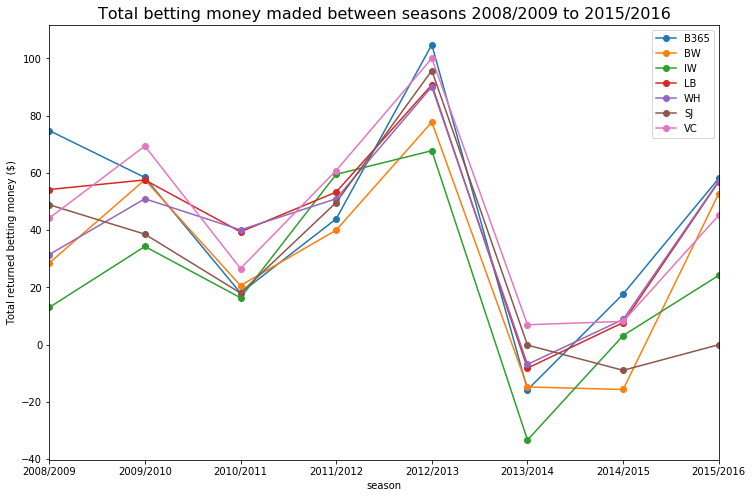

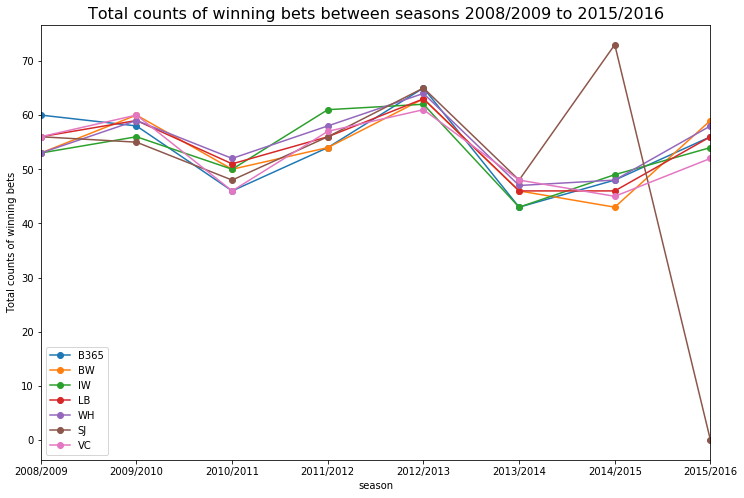

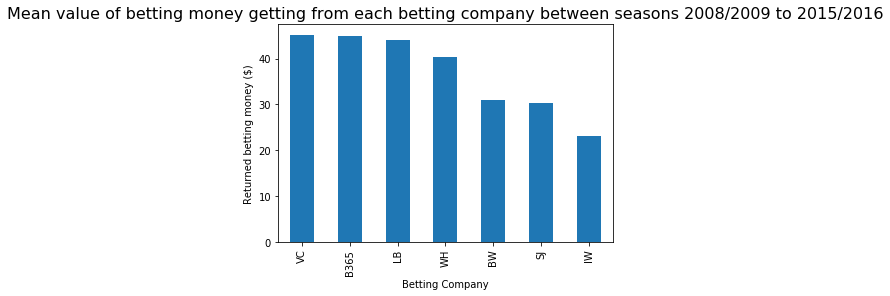

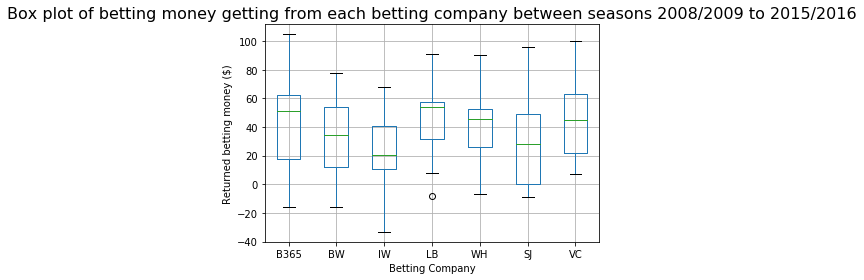

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, the total returned betting money will be little positive and negative for the seasons 2013/2014 and 2014/2015
2) In average, the betting company "VC" will returned the most betting money with the current betting criteria


***********************************
***** Spain LIGA BBVA *****
***********************************


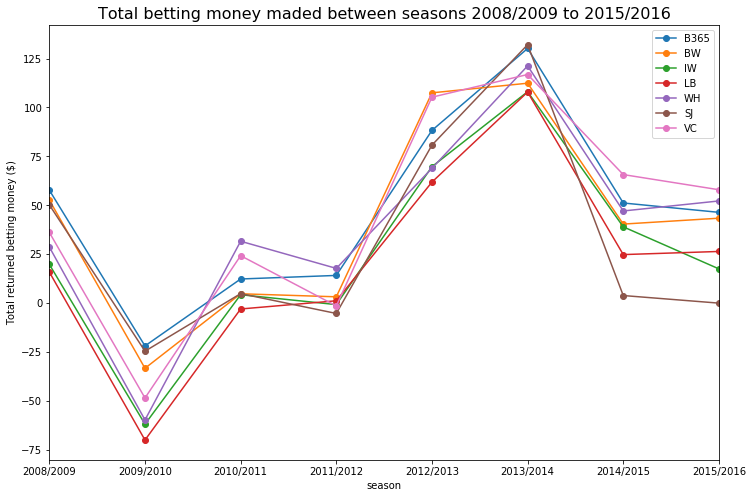

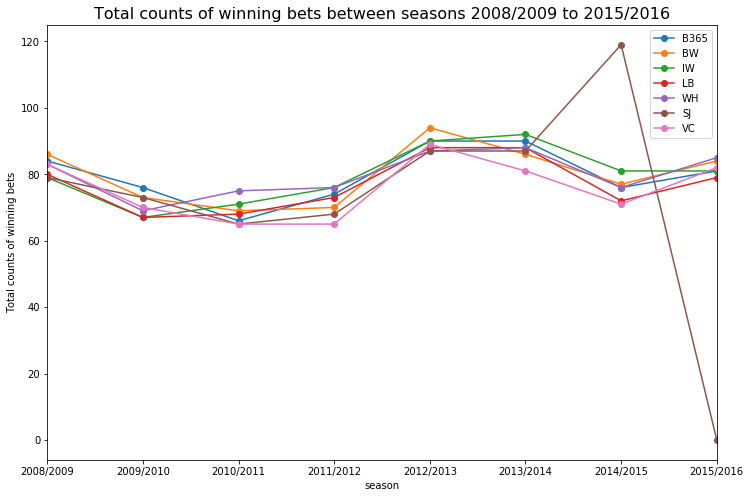

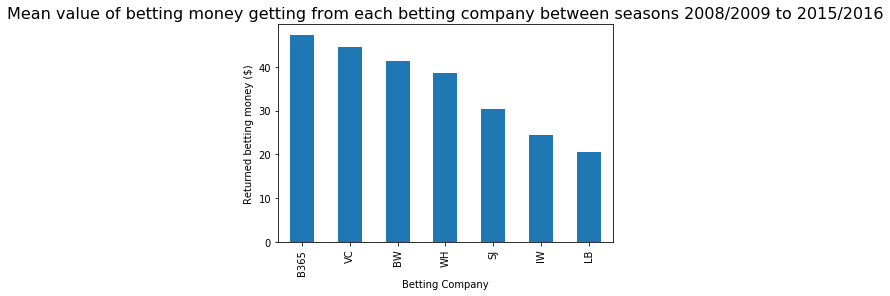

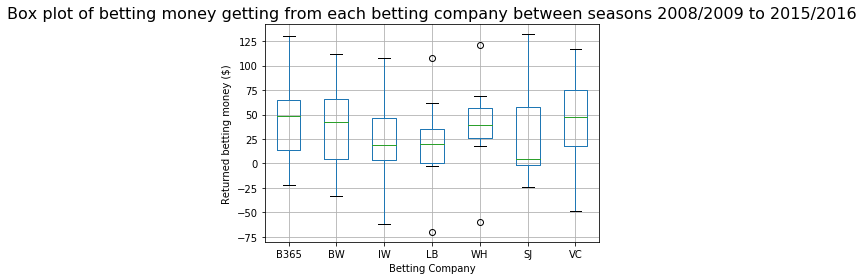

+++++++++++++++++++++++++++++++++++
Observations: 
1) With our betting criteria, the total returned betting money will be negative for the season 2009/2010 and will be positive and negative for the seasons 2010/2011 and 2011/2012
2) In average, the betting company "B365" will returned the most betting money with the current betting criteria, followed by "VC"




In [29]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.

numPlot = 0;

for cnt in range(len(allLeagues)):
    league_name = allLeagues[cnt];
    print('***********************************');
    print('***** {} *****'.format(league_name));
    print('***********************************');
    
    df_bid_money = allBiddingResults_split[league_name]['money'];
    df_bid_numwins = allBiddingResults_split[league_name]['numwins'];

    
    ## Line chart - bidding money
    plt.figure(numPlot);
    numPlot += 1;
    
    df_bid_money.plot(figsize=(12,8),marker='o');
    plt.title('Total betting money maded between seasons 2008/2009 to 2015/2016' , fontsize=16);
    plt.ylabel('Total returned betting money ($)');
    plt.show();
    
    ## Line chart - Total number of winning bids
    plt.figure(numPlot);
    numPlot += 1;
    
    df_bid_numwins.plot(figsize=(12,8),marker='o');
    plt.title('Total counts of winning bets between seasons 2008/2009 to 2015/2016' , fontsize=16);
    plt.ylabel('Total counts of winning bets');
    plt.show();
    
    
    ## Bar chart for mean values
    plt.figure(numPlot);
    numPlot += 1;    
    
    df_bid_money_mean = df_bid_money.mean();
    df_bid_money_mean.sort_values(ascending=False, inplace=True);

    df_bid_money_mean.plot.bar()
    plt.title('Mean value of betting money getting from each betting company between seasons 2008/2009 to 2015/2016' , fontsize=16);
    plt.xlabel('Betting Company');
    plt.ylabel('Returned betting money ($)');
    plt.show();

    ## Boxplot
    plt.figure(numPlot);
    numPlot += 1;

    df_bid_money.boxplot();
    plt.title('Box plot of betting money getting from each betting company between seasons 2008/2009 to 2015/2016' , fontsize=16);
    plt.xlabel('Betting Company');
    plt.ylabel('Returned betting money ($)');
    plt.show()
    
    print('+++++++++++++++++++++++++++++++++++');
    print('Observations: ')
    if (cnt == 0):
        # Belgium Jupiler League
        print('1) With our betting criteria, the total returned betting money will be little positive and negative for the seasons 2010/2011, 2011/2012, 2014/2015 ')
        print('2) The betting data is not available for the season 2013/2014');
        print('3) In average, the betting company "VC" will returned the most betting money with the current betting criteria')
    elif (cnt == 1):
        # England Premier League
        print('1) With our betting criteria, in the season 2009/2010, we will lose money for some betting companies and will gain little money from the rest');
        print('2) However, the line chart for the returned betting money shows that, after the season 2009/2010, the returned betting data will be increased quite significantly with the current betting criteria')
        print('3) In average, the betting company "VC" will returned the most betting money with the current betting criteria')
    elif (cnt == 2):
        # France Ligue 1
        print('1) The line for the returned betting money shows both negative and positive returned betting money in the seasons 2011/2012, 2013/2014, and 2014/2015')
        print('2) In average, the betting company "VC" will returned the most betting money with the current betting criteria although is not quite significant as in other leagues')
    
    elif (cnt == 3):
        # Germany 1. Bundesliga
        print('1) With our betting criteria, in the season 2013/2014, we will lose money for some betting companies and will gain little money from the rest');
        print('2) In average, the betting company "VC" will returned the most betting money with the current betting criteria')        
    
    elif (cnt == 4):
        # Italy Serie A 
        print('1) With our betting criteria, the total returned betting money will be negative for the seasons 2009/2010 and 2013/2014 and other seasons will have both positive and negative values')
        print('2) In average, the betting company "VC" will returned the most betting money with the current betting criteria and this value is much smaller than other leagues. Additionally, some bettings companies will return the negative betting money with the current betting criteria');
    
    elif (cnt == 5):
        # Netherlands Eredivisie 
        print('1) With our betting criteria, we will lose a lot of money from all betting companies in the season 2009/2010, we will both lose and gain money for other seasons');
        print('2) In average, the betting company "VC" will returned the most betting money with the current betting criteria and this value is much smaller than other leagues. Additionally, some bettings companies will return the negative betting money with the current betting criteria');
        
    elif (cnt == 6):
        # Portugal Liga ZON Sagres
        print('1) With our betting criteria, we will lose a lot of money from all betting companies in the seasons 2009/2010, 2011/2012 and 2012/2013, we will both lose and gain money for other seasons');
        print('2) In average, the betting company "B365" will returned the most betting money (less than $10), followed by "VC" with the current betting criteria and this value is much smaller than other leagues. Additionally, all other bettings companies will return the negative betting money with the current betting criteria');

    elif (cnt == 7):
        # Scotland Premier League  
        print('1) With our betting criteria, the total returned betting money will be little positive and negative for the seasons 2013/2014 and 2014/2015')
        print('2) In average, the betting company "VC" will returned the most betting money with the current betting criteria')    
        
    elif (cnt == 8):
        # Spain LIGA BBVA 
        print('1) With our betting criteria, the total returned betting money will be negative for the season 2009/2010 and will be positive and negative for the seasons 2010/2011 and 2011/2012')
        print('2) In average, the betting company "B365" will returned the most betting money with the current betting criteria, followed by "VC"')    
        
    print('\n');


### Research Question 2  (Which league gives the highest betting return)

                               mean
England Premier League    67.647500
Germany 1. Bundesliga     59.077857
Scotland Premier League   36.955893
Spain LIGA BBVA           35.295000
France Ligue 1            18.815179
Belgium Jupiler League    15.767500
Netherlands Eredivisie     9.914464
Italy Serie A              3.517321
Portugal Liga ZON Sagres  -4.009286


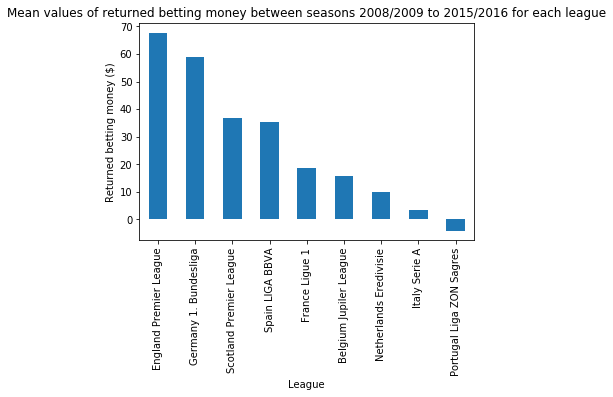

+++++++++++++++++++++++++++++++++++
Observations: 
With the current betting criteria, we should make the betting in the England Premier League because it returns the most betting money in average


In [30]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.

# Get the mean bidding money for each league
mean_data = [];
for cnt in range(len(allLeagues)):
    league_name = allLeagues[cnt];
    
    df_money = allBiddingResults_split[league_name]['money'];
    mean_data.append(df_money.mean().mean());

# Create a dataframe and descendingly sort the mean data    
df_mean = pd.DataFrame({'mean': mean_data}, index=allLeagues);   
df_mean.sort_values('mean',ascending=False, inplace=True);
print(df_mean)

# Create a bar chart
plt.figure();
df_mean['mean'].plot.bar()
plt.title('Mean values of returned betting money between seasons 2008/2009 to 2015/2016 for each league');    
plt.xlabel('League');    
plt.ylabel('Returned betting money ($)');
plt.show();

print('+++++++++++++++++++++++++++++++++++');
print('Observations: ')
print('With the current betting criteria, we should make the betting in the England Premier League because it returns the most betting money in average')


<a id='conclusions'></a>
## Conclusions


### Research Question 1 (Which Bidding Company gives the most bidding return)

The charts in the Research Question1 show that the 'VC' company returns the most bidding money if we only bet `$`1 for the result with the highest winning odds in almost all leagues except
1) Portugal Liga ZON Sagres 
2) Spain LIGA BBVA

where B365 returns higher mean value of the returned betting money (We should not bid in "Portugal Liga ZON Sagres" anyway because the betting money is very small and most companies have a negative mean value.

### Research Question 2  (Which league gives the highest bidding return)

With the current betting criteria (only bet `$1` for the result with the highest winning odds), "England Premier League" return the maximum mean value of the returned betting money (`$`67.65) and followed by "Germany 1. Bundesliga" (`$`59) and "Scotland Premier League" (`$`37). 
The league that I should not bet on with this criteria is "Portugal Liga ZON Sagres" where the mean value of the returned betting money is negative (`$`4)

### Limitations

I need to drop a few leagues ("Poland Ekstraklasa" and "Switzerland Super League") and betting companies ("PS", "GB" and "BS") from this analysis because their betting data is not available and they might/might not return higher returned betting money for the current criteria.


In [82]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0